In [9]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm
import os

In [10]:

def forcefield(x,x_0,k):
    return (x_0-x)*k
def timestep(x,force,Diffusion_particle,dt):
    return x+force*dt+rd.normal()*np.sqrt(2*Diffusion_particle*dt)
def make_trajectory(time,dt,k,Diffusion_particle,Diffusion_oscillator):
    x=rd.normal()
    x_0=0
    treyectory_particle=[x]
    treyectory_oscillator=[0]
    for i in range(int(time/dt)):
        force=forcefield(x,x_0,k)
        x_0+=rd.normal()*np.sqrt(2*Diffusion_oscillator*dt)
        x=timestep(x,force,Diffusion_particle,dt)
        treyectory_particle.append(x)
        treyectory_oscillator.append(x_0)
    return treyectory_particle,treyectory_oscillator
def mean_square_displacement(time_list,trajectory,sample_nuber=100,samplelength=100):
    sample_list=[]
    for i in range(sample_nuber):
        j=rd.randint(len(trajectory)-int(samplelength/dt))
        sample=trajectory[j:j+int(samplelength/dt)]
        beginning=sample[0]
        sample=[(s-beginning)**2 for s in sample]
        sample_list.append(sample)
    msd_trajectory=[np.mean([sample[i] for sample in sample_list]) for i in range(int(samplelength/dt)-1)]
    return    msd_trajectory   
def bin_data(data, bin_count):
    bin_indices = np.linspace(0, len(data), bin_count + 1, dtype=int)
    return np.add.reduceat(data, bin_indices[:-1]) / (bin_indices[1:] - bin_indices[:-1])

def calculate_segment_contribution(args):
    segment, dt, Tao, timespan, multiplier, max_mbr_points = args
    forward_sampling = int(timespan / dt)
    backward_sampling = int(Tao / dt)
    
    mbr_trajectory = np.zeros(min(forward_sampling, max_mbr_points))
    
    # Ensuring we don't go out of bounds
    sample_starts = np.arange(backward_sampling + 1, len(segment) - forward_sampling - 1)
    
    rng = np.random.default_rng()
    random_samples = rng.choice(sample_starts, size=min(100, len(sample_starts)), replace=False)
    b_mbr_samples = [segment[s] - segment[s - backward_sampling] for s in random_samples]    
    sigma = np.std(b_mbr_samples)
    b_cutoff = sigma * multiplier
    n_valid_points =0
    for start in sample_starts:
        x_0_mbr = segment[start]
        #print(x_0_mbr)
        #assert x_0_mbr is float or x_0_mbr is int, f" x_0_mbr is {type(x_0_mbr)}"
        
        d_mbr = x_0_mbr - segment[start - backward_sampling]
        
        if abs(d_mbr) > b_cutoff:
            sample = segment[start : start + forward_sampling]
            sample_to_add = (-(sample - x_0_mbr) / d_mbr) * 1 / len(sample_starts)
            if forward_sampling > max_mbr_points:
                sample_to_add = bin_data(sample_to_add, max_mbr_points)
            mbr_trajectory += sample_to_add
            n_valid_points += 1    
    return mbr_trajectory*(len(sample_starts)/n_valid_points)

def mean_back_realxation(dt, trajectory, Tao, timespan, multiplier=1, num_threads=None, max_segments = None, max_mbr_points = 1000):
    if num_threads is None:
        num_threads = os.cpu_count()

    forward_sampling = int(timespan / dt)
    backward_sampling = int(Tao / dt)
    if max_segments is None:
        max_segments = forward_sampling 
    segments = []
    segment_size = min(len(trajectory) // num_threads,max_segments)
    print(f"Segment size: {segment_size}")
    for i in range(0, len(trajectory), segment_size):
        start = max(i - backward_sampling, 0)
        end = min(i + segment_size + forward_sampling, len(trajectory))
        # If this isn't the last segment, ensure the end doesn't overlap with the start of the next segment
        if i + segment_size+ forward_sampling < len(trajectory):
            segments.append(trajectory[start:end])
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        args = [(segment, dt, Tao, timespan, multiplier, max_mbr_points) for segment in segments]
        results = list(tqdm(executor.map(calculate_segment_contribution, args), total=len(segments), desc="Processing segments", position=0, leave=True))
    mbr_trajectory = np.mean(results, axis=0)
    return mbr_trajectory

def analytical_mean_back_realxation(dt,time,k,Diffusion_particle,Diffusion_oscillator):
    time_list=np.linspace(0,time,int(time/dt))
    prefactor=1/2*(1-Diffusion_oscillator/Diffusion_particle)
    analytical_mbr=[prefactor*(1-np.exp(-k*t)) for t in time_list]
    return analytical_mbr


In [11]:
os.cpu_count()

12

In [12]:
k=1
time=1000
dt=0.001
Diffusion_particle=1
Diffusion_oscillator=.5

In [13]:
trajetreyectory_particle,treyectory_oscillatorctory=make_trajectory(time,dt,k,Diffusion_particle,Diffusion_oscillator)
time_list=np.linspace(0,time,int(time/dt)+1)

: 

In [6]:
mbr_timespan=10
Tao=dt
mbr=mean_back_realxation(dt,trajetreyectory_particle,Tao,mbr_timespan,multiplier=1,max_mbr_points = 100000)

Segment size: 10000


Processing segments:   0%|          | 0/99 [00:00<?, ?it/s]

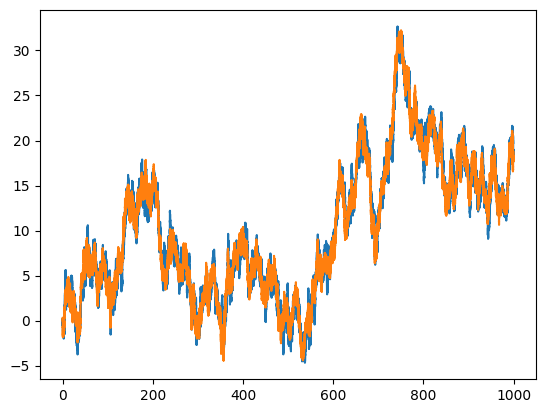

In [7]:
plt.plot(time_list, trajetreyectory_particle)
plt.plot(time_list, treyectory_oscillatorctory)

Text(0, 0.5, 'MBR')

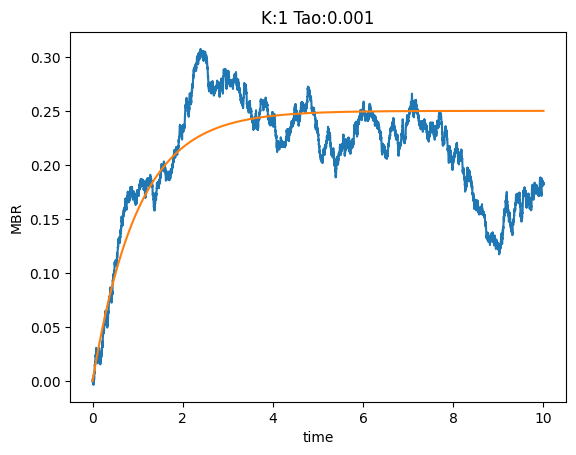

In [8]:
analytical_mbr=analytical_mean_back_realxation(dt,mbr_timespan,k,Diffusion_particle,Diffusion_oscillator)
plt.plot(np.linspace(0,mbr_timespan,len(mbr)),mbr)
plt.plot(np.linspace(0,mbr_timespan,len(analytical_mbr)),analytical_mbr)
plt.title("K:"+str(k)+" Tao:"+str(Tao))
plt.xlabel("time")
plt.ylabel("MBR")

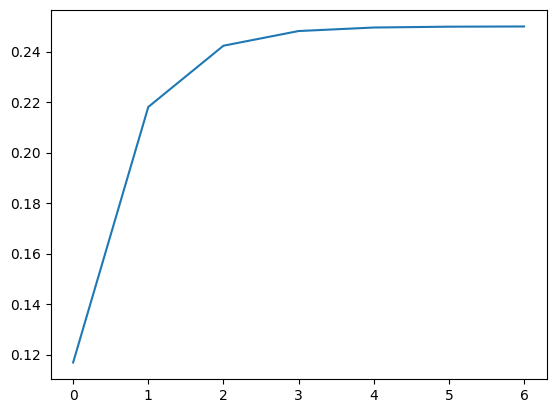

In [92]:
binned_mbr = bin_data(analytical_mbr, 7)
plt.plot(binned_mbr)

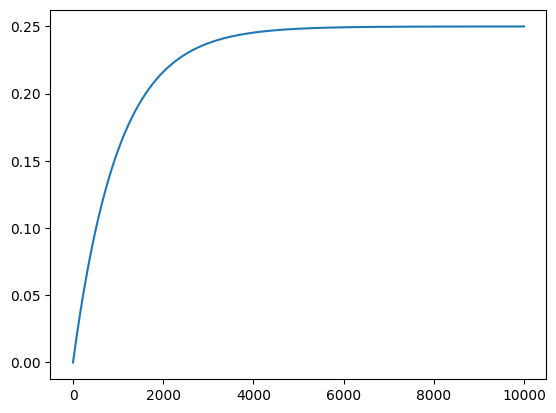

In [88]:
plt.plot(analytical_mbr)